# Multihead Attention

In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [44]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim)) # x : bt_size, seq_len, input_dim

输入数据形状为 `(batch_size, sequence_length, input_dim)`。这表示在每个epochs中，有 batch_size 个样本，每个样本是一个长度为 sequence_length 的序列，每个元素的维度为 input_dim。

In [45]:
x.size()

torch.Size([1, 4, 512])

In [46]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

**问题：为什么要定义一个全连接层，而且输出维度为什么是 3 * d_model？**

答案：因为需要从同一个输入 x 生成三个不同的向量：查询（Query）、键（Key）和值（Value）。这三个向量都通过 v_layer 生成，所以 v_layer 的输出实际上是这三个向量的集合。(一次生成，后续分开)

In [47]:
qkv = qkv_layer(x)  # linear只有最会维度进行变化 （*，H_in）---> (*,H_out)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

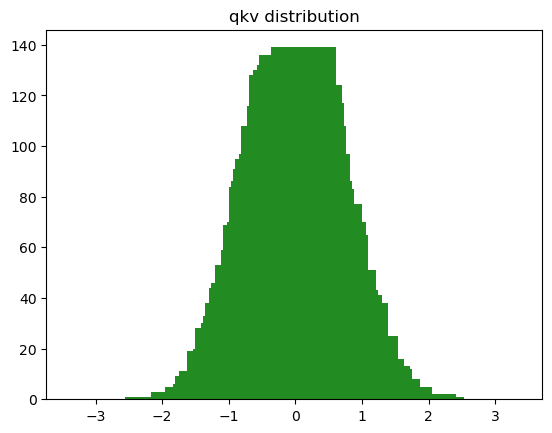

In [19]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) *3
plt.bar(x_val, y_val, align='center',color=['forestgreen'])
plt.title('qkv distribution')

**问题：为什么要查看 qkv 的分布？**

答案：查看 qkv 的分布有助于我们理解模型的内部状态和行为。例如，如果分布非常偏斜或集中在某个特定的范围内，那么可能需要调整模型参数或使用不同的初始化策略。此外，这也可以帮助我们调试模型，确认是否有意外的行为（如值的爆炸或消失）。

**问：qkv只是一个[1, 4, 1536]第向量，如何计算分布的？**

torch.histc 函数会将张量视为一个一维的数据流，并对所有的数据点进行统计。

为了更好地理解这个过程，我们可以将其拆解为以下步骤：

首先，torch.histc 函数会将 qkv 张量中的所有元素拉平成一个一维的数组。在例子中，得到一个具有 1 * 4 * 1536 = 6144 个元素的数组。
接着，torch.histc 函数会对这个数组中的元素进行分箱统计。bins 参数定义了分箱的数量，min 和 max 参数定义了分箱的范围。在你的例子中，这将把所有的元素分到 200 个箱子中，每个箱子的范围是 (-3, 3)。
最后，torch.histc 函数会返回一个数组，其中每个元素表示对应箱子中的元素数量。


In [20]:
num_heads = 8
head_dim = d_model // num_heads # 1536/8 = 192
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

qkv 被重塑和拆分成 num_heads 个头，每个头的维度是 head_dim。每个头使用的 q、k、v 是全体 q、k、v 经过线性变换后的部分数据，而不是直接从原始的 q、k、v 中取一部分

In [21]:
qkv.shape

torch.Size([1, 4, 8, 192])

**问题：为什么要改变 qkv 的形状？**

答案：在多头注意力机制中，输入的 d_model 维度的数据会被分成多个“头”，每个头处理一部分信息。这样可以让模型在处理输入时更加灵活，因为每个头可以学习并专注于捕获不同的信息

**问题：为什么在最后一个维度上将数据划分为了 num_heads 个部分？**

答案：在深度学习模型中，最后一个维度通常用来表示数据的特征，而前面的维度则用来表示数据的结构。在这个上下文中，num_heads 是我们的“头”的数量，每个“头”都需要处理一部分特征。因此，我们在最后一个维度上将数据划分为了 num_heads 个部分。

这样做的好处是，可以让我们在后续的计算中，更方便地处理每个“头”的数据。例如，当我们需要计算每个“头”的注意力权重时，我们可以直接对最后一个维度（即 3 * head_dim）进行操作，而不需要关心“头”的数量。

In [22]:
qkv = qkv .permute(0,2,1,3)
qkv.shape

torch.Size([1, 8, 4, 192])

通过将 qkv 的维度重排列为 `(batch_size, num_heads, sequence_length, 3 * head_dim)`，我们可以更方便地处理每个头的数据，因为现在每个头的数据都在连续的内存位置中。

In [23]:
q, k, v = qkv.chunk(3, dim = -1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

# Self Attention for multiple heads

For a single head:

$$
\begin{aligned}
\text { self attention } & =\operatorname{softmax}\left(\frac{Q \cdot K^T}{\sqrt{d_k}}+M\right) \\
\text { new } \mathrm{V} & =\text { self attention. } V
\end{aligned}
$$


In [24]:
import math

d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

**问题：为什么要计算缩放的点积注意力，以及为什么要对结果进行缩放？**

答案：在 Transformer 模型的注意力机制中，我们使用查询 `q` 和键 `k` 的点积来计算注意力权重。然而，当查询和键的维度 `d_k` 较大时，点积的结果可能会非常大，这会导致 softmax 函数（通常用于计算注意力权重）在反向传播时梯度消失，从而影响模型的训练。

为了解决这个问题，我们引入了缩放因子 $1/\sqrt(d_k)$。这个缩放因子可以确保点积的结果在一个合理的范围内，从而避免 softmax 函数的梯度消失问题。

至于 scaled 的形状 `(batch_size, num_heads, sequence_length, sequence_length)`。在最后两个维度上进行的矩阵乘法，即对每个头和每个批次的数据，我们都计算了所有查询和键的点积。

In [26]:
y = torch.randn(2, 3)
torch.transpose(y, 1, 0)

tensor([[-0.7805, -0.8075],
        [-1.6576, -1.1753],
        [-0.4163,  0.5748]])

**问题：为什么多维度张量需要使用 PyTorch 的 transpose 或 permute 函数进行转置，而不能使用 NumPy 的 T 属性？**

答案：NumPy 的 T 属性和 transpose 函数在处理二维数组（即矩阵）时表现得很好，它们可以将二维数组的行和列进行交换。然而，对于高于二维的数组，T 属性只会反转维度的顺序，这可能并不是我们想要的结果。

例如，对于一个形状为 (a, b, c) 的三维数组，T 属性会得到一个形状为 (c, b, a) 的数组。但在许多情况下，我们可能希望交换其他两个维度，如 (a, c, b) 或 (b, a, c)，这时就需要使用 transpose 或 permute 函数了。

PyTorch 的 transpose 和 permute 函数提供了更强大的功能，它们可以交换张量的任意两个维度，或者重新排列所有维度的顺序。

In [27]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

**问题：mask[0][1] 具体表示什么？**

答案：在这个上下文中，mask[0][1] 用于选择 mask 张量中第一个批次（batch）的第二个头（head）的遮罩。在多头注意力机制中，每个批次包含多个头，每个头都有自己的查询、键和值向量，以及对应的遮罩。这里，mask[0][1] 就是选择了第一个批次的第二个头的遮罩。

In [28]:
(scaled + mask) [0][0]

tensor([[-0.1941,    -inf,    -inf,    -inf],
        [ 0.3471,  0.3118,    -inf,    -inf],
        [-0.2590,  0.0068, -0.0838,    -inf],
        [ 0.2202,  0.2823,  0.3527, -0.1306]], grad_fn=<SelectBackward0>)

**问题：为什么需要创建这样的 mask 张量，它的作用是什么？**

答案：这个 mask 张量是用于遮罩序列的一部分，防止模型看到序列的未来信息。在自然语言处理任务中，特别是在训练语言模型时，我们希望模型在预测下一个词时，只能看到当前词及其之前的词，而不能看到未来的词。这样的遮罩可以帮助我们实现这个目标。

具体来说，mask 张量的上三角部分是负无穷，表示序列的未来信息；下三角部分是零，表示序列的当前和过去的信息。当我们在计算注意力权重时，将这个 mask 添加到 scaled 上，因为 softmax 函数对于负无穷的输入会输出零，所以模型就无法看到序列的未来信息了。

In [29]:
scaled = scaled + mask

In [30]:
attention = F.softmax(scaled, dim=-1)
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5088, 0.4912, 0.0000, 0.0000],
        [0.2860, 0.3732, 0.3408, 0.0000],
        [0.2558, 0.2721, 0.2920, 0.1801]], grad_fn=<SelectBackward0>)

In [33]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

# Function

In [35]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k=q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1,-2))/math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled,dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [36]:
values, attention = scaled_dot_product(q, k, v, mask=None)
attention.shape

torch.Size([1, 8, 4, 4])

In [37]:
attention[0][0]

tensor([[0.2112, 0.3360, 0.3056, 0.1473],
        [0.3646, 0.3520, 0.1323, 0.1511],
        [0.2257, 0.2945, 0.2690, 0.2108],
        [0.2558, 0.2721, 0.2920, 0.1801]], grad_fn=<SelectBackward0>)

In [38]:
values.size()

torch.Size([1, 8, 4, 64])

In [39]:
values = values.reshape(batch_size, sequence_length, num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [40]:
linear_layer = nn.Linear(d_model,d_model)
linear_layer

Linear(in_features=512, out_features=512, bias=True)

In [41]:
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

In [42]:
out

tensor([[[ 0.1040,  0.1237,  0.0365,  ...,  0.0254,  0.2057,  0.1023],
         [ 0.0542,  0.2107,  0.2195,  ..., -0.0147, -0.1602,  0.3932],
         [-0.0821,  0.1747, -0.3093,  ...,  0.3298,  0.1966,  0.0191],
         [-0.0452,  0.0256, -0.0232,  ...,  0.1425,  0.1206,  0.0033]]],
       grad_fn=<ViewBackward0>)

# (All) MultiheadAttention

In [48]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k ,v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads

        self.head_dim = d_model //num_heads
        self.qkv_layer = nn.Linear(input_dim, 3*d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask = None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")

        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")

        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3*self.head_dim)
        print(f"qkv.size(): {qkv.size()}")

        qkv  = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")

        q, k, v = qkv.chunk(3, dim = -1)
        print(f"q size:{q.size()}, k size:{k.size()}, v size:{v.size()}")

        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention size: {attention.size()}")

        values = values.reshape(batch_size, sequence_length, self.num_heads*self.head_dim)
        print(f"values.size(): {values.size()}")

        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


# Input without mask

In [50]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)


x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size:torch.Size([30, 8, 5, 64]), k size:torch.Size([30, 8, 5, 64]), v size:torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention size: torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


# Input with mask

In [51]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = MultiheadAttention(input_dim, d_model, num_heads)

out = model.forward(x, mask)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size:torch.Size([30, 8, 5, 64]), k size:torch.Size([30, 8, 5, 64]), v size:torch.Size([30, 8, 5, 64])


RuntimeError: The size of tensor a (5) must match the size of tensor b (4) at non-singleton dimension 3

# PyTorch API

- [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [torch.reshape](https://pytorch.org/docs/stable/generated/torch.reshape.html?highlight=reshape#torch.reshape)